# Relax Data Science Challenge

**Goal: Defining   an    "adopted   user"   as   a   user   who has   logged   into   the   product   on   three   separate days   in   at   least   one   seven­day   period,   identify   which   factors   predict   future   useradoption.**

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
df_user_engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates= ['time_stamp'], encoding = "ISO-8859-1")
df_users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

### **EDA and Data Preprocessing**

**Inspect head.**

In [4]:
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Goal is to make a list of "adopted users" given criteria. Number of all users in data:

In [5]:
len(df_user_engagement['user_id'].unique())

8823

**Remove time stamps and get just dates.**

In [6]:
df_user_engagement['time_stamp'] = pd.to_datetime(df_user_engagement['time_stamp'])

In [7]:
df_user_engagement['dates']  = df_user_engagement['time_stamp'].dt.date

In [8]:
df_user_engagement = df_user_engagement.drop(["time_stamp"], axis=1)

In [9]:
df_user_engagement.head()

,user_id,visited,dates
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29
3,2,1,2013-12-09
4,2,1,2013-12-25


**Drop same day duplicates for each user_id**

In [10]:
df_user_engagement.drop_duplicates(['user_id', 'dates'])

,user_id,visited,dates
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29
3,2,1,2013-12-09
4,2,1,2013-12-25
5,2,1,2013-12-31
6,2,1,2014-01-08
7,2,1,2014-02-03
8,2,1,2014-02-08
9,2,1,2014-02-09


**Group by user_id and create a column that shifts forward by three days.**

In [11]:
df_user_engagement['shifted_date'] = df_user_engagement.groupby(['user_id'])['dates'].shift(-2)

In [12]:
df_user_engagement.head(50)

,user_id,visited,dates,shifted_date
0,1,1,2014-04-22,NaN
1,2,1,2013-11-15,2013-12-09
2,2,1,2013-11-29,2013-12-25
3,2,1,2013-12-09,2013-12-31
4,2,1,2013-12-25,2014-01-08
5,2,1,2013-12-31,2014-02-03
6,2,1,2014-01-08,2014-02-08
7,2,1,2014-02-03,2014-02-09
8,2,1,2014-02-08,2014-02-13
9,2,1,2014-02-09,2014-02-16


In [13]:
df_user_engagement.dropna()

,user_id,visited,dates,shifted_date
1,2,1,2013-11-15,2013-12-09
2,2,1,2013-11-29,2013-12-25
3,2,1,2013-12-09,2013-12-31
4,2,1,2013-12-25,2014-01-08
5,2,1,2013-12-31,2014-02-03
6,2,1,2014-01-08,2014-02-08
7,2,1,2014-02-03,2014-02-09
8,2,1,2014-02-08,2014-02-13
9,2,1,2014-02-09,2014-02-16
10,2,1,2014-02-13,2014-03-09


In [14]:
df_user_engagement['date_diff'] = df_user_engagement['shifted_date'] - df_user_engagement['dates']

In [15]:
df_user_engagement = df_user_engagement.loc[(df_user_engagement['date_diff'] < '7 days')]

In [16]:
df_user_engagement.head(50)

,user_id,visited,dates,shifted_date,date_diff
7,2,1,2014-02-03,2014-02-09,6 days
8,2,1,2014-02-08,2014-02-13,5 days
25,10,1,2013-02-14,2013-02-19,5 days
28,10,1,2013-02-26,2013-03-02,4 days
29,10,1,2013-03-01,2013-03-05,4 days
33,10,1,2013-03-15,2013-03-20,5 days
34,10,1,2013-03-17,2013-03-22,5 days
35,10,1,2013-03-20,2013-03-26,6 days
38,10,1,2013-04-07,2013-04-13,6 days
39,10,1,2013-04-11,2013-04-14,3 days


In [17]:
adopted_users = (df_user_engagement['user_id'].unique())

In [18]:
print (adopted_users)

[    2    10    20 ... 11969 11975 11988]


In [19]:
len(adopted_users)

1602

### 3. Create Visualizations

In [20]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [21]:
df_users = df_users.dropna()

In [22]:
df_users.invited_by_user_id = df_users.invited_by_user_id.astype(int)

In [23]:
def is_adopted_user(idnum):
    if idnum in adopted_users:
        return 1
    else:
        return 0

In [24]:
df_users['adopted_user'] = df_users['object_id'].apply(is_adopted_user)

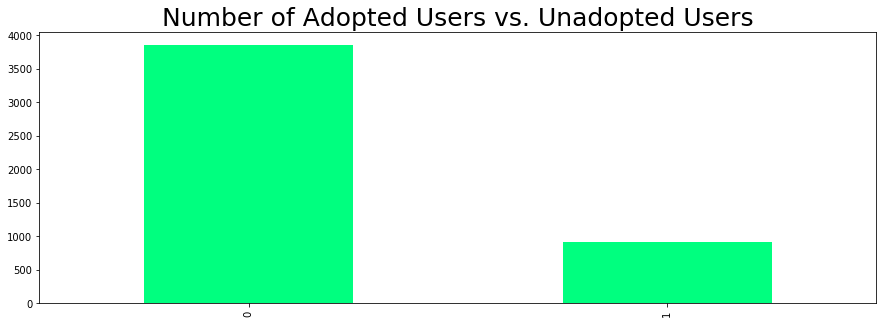

In [25]:
df_users.adopted_user.value_counts().plot(kind='bar',color='springgreen')
plt.title("Number of Adopted Users vs. Unadopted Users", fontsize=25)

What features determine who becomes an adopted user and who does not?

Let's consider the features "opted_in_to_mailing_list", "enabled_for_marketing_drip", "org_id", and "invited_by_user_id".

In [26]:
features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
X = df_users[features] 
y = df_users.adopted_user 

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [28]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7529313232830821


In [29]:
for feat, importance in zip(features, clf.feature_importances_):
    print ('Feature: {f}, Importance: {i}'.format(f=feat, i=importance))

Feature: opted_in_to_mailing_list, Importance: 0.021948011926178658
Feature: enabled_for_marketing_drip, Importance: 0.014411847320114383
Feature: org_id, Importance: 0.4192353425557787
Feature: invited_by_user_id, Importance: 0.5444047981979283


It looks like who invited a given user is the most predictive feature. 

There is another feature, 'creation_source', which is categorical. We can convert this to numerical codes and include it in the classifier.

In [30]:
df_users['creation_source_code'] = df_users['creation_source'].astype('category')

In [31]:
df_users['creation_source_code'] = df_users.creation_source_code.cat.codes

In [32]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_code
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,0


In [33]:
features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'creation_source_code']
X = df_users[features] 
y = df_users.adopted_user 

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [35]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7529313232830821


In [36]:
for feat, importance in zip(features, clf.feature_importances_):
    print ('Feature: {f}, Importance: {i}'.format(f=feat, i=importance))

Feature: opted_in_to_mailing_list, Importance: 0.015352819341178055
Feature: enabled_for_marketing_drip, Importance: 0.010885690527753997
Feature: org_id, Importance: 0.4286831832252095
Feature: invited_by_user_id, Importance: 0.5318612993029803
Feature: creation_source_code, Importance: 0.013217007602878118


Including 'creation source' in the classifier actually reduced accuracy by a negligible amount.  This is clearly not an important feature.  What is notable that its feature importance is similar to 'enabled_for_marketing_drip' and 'opted_in_to_mailing_list' features.  This means that 'org_id' and 'invited_by_user_id' are, by far, the most important features for determining who will be an "adopted user".

Thus, there are certain organizations and inviting users that are more likely than others to be linked to user adoption. This is worth exploring through visiualization. 

In [37]:
adopted_users =  df_users[df_users['adopted_user']==1]

In [38]:
adopted_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_code
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1,1
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143,1,1
32,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79,1,0
42,43,2012-12-31 07:13:17,Gomes Beatrice,vgqmpljq@yyyxt.com,GUEST_INVITE,1.366010e+09,0,0,63,149,1,0
49,50,2012-06-03 11:02:08,Oliveira Gabrielly,GabriellyAlmeidaOliveira@gmail.com,GUEST_INVITE,1.350990e+09,0,0,61,50,1,0


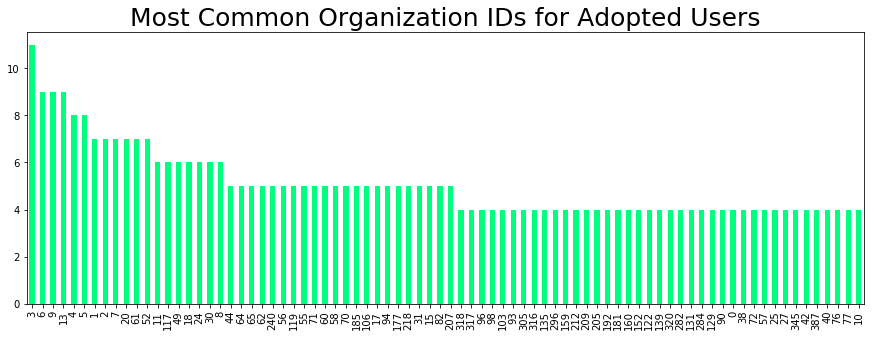

In [39]:
adopted_users.org_id.value_counts().nlargest(80).plot(kind='bar',color='springgreen')
plt.title("Most Common Organization IDs for Adopted Users", fontsize=25)

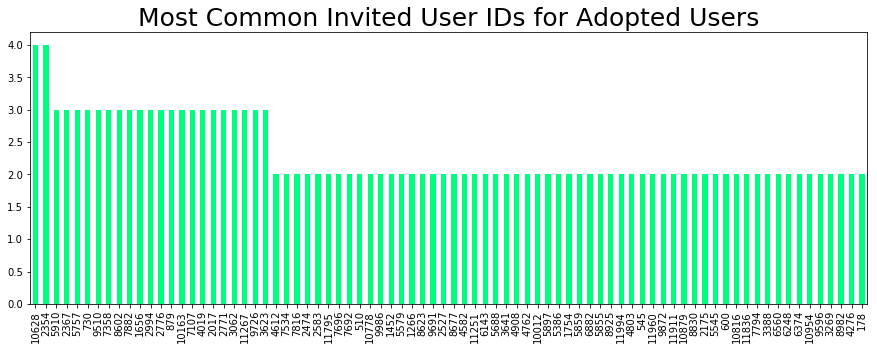

In [40]:
adopted_users.invited_by_user_id.value_counts().nlargest(80).plot(kind='bar',color='springgreen')
plt.title("Most Common Invited User IDs for Adopted Users", fontsize=25)

These graphs demonstrate that there are a few organizations and inviting users in the dataset that have a significantly higher count of adopted users that the vast majority of other observations in the dataset.